# Starbucks Capstone Challenge 

Project design by Udacity and Starbucks

Notebook author: Zhen-Yen Chan

Version: 2.0 

Date created: 22/08/2022

Last updated: 26/08/2022

This notebook processes and analyses transaction, demographic and offer data from Starbucks, trains several classification models, performs hyperparameter tuning and produces visualisations to predict which offer type each customer will respond best to. The CRISP-DM process is followed.

## 1. Business Understanding

### 1.1 Introduction (this section is provided by Udacity)

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. 

**Assumption**: Informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, we assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

**Caveat**: Someone using the app might make a purchase through the app without having received an offer or seen an offer.

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### 1.2 Problem Formulation

In this project, I will build machine learning models to predict whether each customer who has seen an offer will complete it. Customers who did not receive an offer or received but did not view it are not relevant to this analysis.

## 2. Data Understanding

### 2.1 Data Sets (this section is provided by Udacity)

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

### 2.2 First look at the data

In [1]:
# import libraries
import numpy as np                               
import pandas as pd                               
import matplotlib.pyplot as plt                  
import seaborn as sns
import math
import json
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# adjust output display size
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)  

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
# preview portfolio data
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
# get data types and count of missing values
portfolio.info()

# there are no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [4]:
# list available channels and convert channels column to string
channel_names = ['web', 'email', 'mobile', 'social']
portfolio['channels'] = portfolio['channels'].astype(str)

In [5]:
# expand the channels column into dummy columns for each channel
for channel in channel_names:
    portfolio[channel] = np.where(portfolio['channels'].str.contains(channel), 1, 0)
portfolio = portfolio.drop('channels', axis = 1)
portfolio

,reward,difficulty,duration,offer_type,id,web,email,mobile,social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0


In [6]:
list(portfolio.offer_type.unique())

['bogo', 'informational', 'discount']

In [7]:
# get summary counts
num_offers = portfolio.id.nunique()
num_offer_types = portfolio.offer_type.nunique()
offer_type_names = list(portfolio.offer_type.unique())
num_channels = len(channel_names)

print(f"The portfolio dataset provides information on {num_offers} offers with {num_offer_types} offer types ({offer_type_names}) delivered through {num_channels} channels ({channel_names}).")

The portfolio dataset provides information on 10 offers with 3 offer types (['bogo', 'informational', 'discount']) delivered through 4 channels (['web', 'email', 'mobile', 'social']).


In [8]:
# load the profile dataset
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [9]:
# get data types and count of missing values
profile.info()

# we need to deal with missing values for gender and income later

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [10]:
# get summary counts

num_customers = profile.id.nunique()
min_age = profile.age.min()
max_age = profile.age.max()
min_income = profile.income.min()
max_income = profile.income.max()

print(f"The profile dataset provides information on {num_customers} customers between the ages of {min_age} and {max_age}. These customers have an income range between {min_income} and {max_income}")

The profile dataset provides information on 17000 customers between the ages of 18 and 118. These customers have an income range between 30000.0 and 120000.0


In [11]:
# load the transcript dataset
transcript.head(5)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [12]:
# get data types and count of missing values
transcript.info()

# there are no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [13]:
# get summary counts

num_records = transcript.shape[0]
event_names = transcript.event.unique()
num_customers_initial = transcript.person.nunique()
test_duration = transcript.time.max()/24

print(f"The original transcript dataset provides information on {num_records} records of activity ({event_names}) over a test period of {test_duration} days for {num_customers_initial} customers.")

The original transcript dataset provides information on 306534 records of activity (['offer received' 'offer viewed' 'transaction' 'offer completed']) over a test period of 29.75 days for 17000 customers.


In [14]:
# select the events 'offer viewed' and 'offer completed' only 
transcript = transcript[transcript.event.isin(['offer viewed', 'offer completed'])]

In [15]:
# deep dive into one customer
transcript[transcript.person == '0009655768c64bdeb2e877511632db8f'].sort_values(['person', 'time'])

,person,event,value,time
77705,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192
139992,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372
168413,0009655768c64bdeb2e877511632db8f,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,414
187554,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},456
228423,0009655768c64bdeb2e877511632db8f,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,528
233413,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},540
258884,0009655768c64bdeb2e877511632db8f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,576


We see that this customer completed 3 different offers during the test period but observing the time column tells us that they did not actually view any offers before completing it. We want to remove these customers from analysis.

## 3. Data Preparation

### 3.1 Transform the transcript table and select customers of interest

In [16]:
# extract offer id only from the value column and drop the original column
transcript['offer_id'] = transcript['value'].apply(lambda x: list(x.values())[0])
transcript = transcript.drop('value', axis=1)
# sort and rearrange columns for readability
transcript = transcript.sort_values(['person', 'offer_id', 'event', 'time'])
transcript = transcript[['person', 'offer_id', 'event', 'time']]
# check number of different offer_ids returned
transcript.offer_id.nunique()

10

In [17]:
def get_complete_time(row):
    if row['event']=='offer completed':
        complete_time = row['time']
    else:
        complete_time = np.nan
    return complete_time

def get_view_time(row):
    if row['event']=='offer viewed':
        view_time = row['time']
    else:
        view_time = np.nan
    return view_time

transcript['complete_time'] = transcript.apply(get_complete_time, axis=1)
transcript['view_time'] = transcript.apply(get_view_time, axis=1)

In [18]:
transcript[transcript.person == 'ffff82501cea40309d5fdd7edcca4a07']

,person,offer_id,event,time,complete_time,view_time
79668,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer completed,198,198.0,NaN
69626,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer viewed,174,NaN,174.0
143788,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,offer completed,384,384.0,NaN
168024,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,offer completed,414,414.0,NaN
258362,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,offer completed,576,576.0,NaN
133074,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,offer viewed,354,NaN,354.0
168022,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,offer viewed,414,NaN,414.0
262475,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,offer viewed,582,NaN,582.0
214717,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer completed,504,504.0,NaN
230690,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer viewed,534,NaN,534.0


In [19]:
# for each combination of person, offer_id and event, select only the first time they completed it 
# and the first time they viewed it (if any)
first_complete_and_view_times = transcript.groupby(['person', 'offer_id']).agg(min_complete_time=pd.NamedAgg(column='complete_time', aggfunc='min'),min_view_time = pd.NamedAgg(column='view_time', aggfunc='min'))

In [20]:
# count number of unique combinations of person and offer_id
len(transcript[['person', 'offer_id']].value_counts())

53671

In [21]:
# for each combination of person and offer_id, join with the first time they viewed or completed that offer (if any)
transcript2 = transcript[['person', 'offer_id']].drop_duplicates()
transcript2 = transcript2.merge(first_complete_and_view_times, on=['person','offer_id'])
transcript2.shape[0]

53671

In [22]:
transcript2[transcript2.person == 'ffff82501cea40309d5fdd7edcca4a07']

,person,offer_id,min_complete_time,min_view_time
53667,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,198.0,174.0
53668,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,384.0,354.0
53669,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,504.0,534.0
53670,ffff82501cea40309d5fdd7edcca4a07,fafdcd668e3743c1bb461111dcafc2a4,60.0,6.0


In [23]:
# select customers with only 2 conditions:
# 1) viewed but did not complete the offer
# 2) completed the offer after viewing it
transcript3 = transcript2[((transcript2.min_complete_time.isnull()) & (transcript2.min_view_time.notnull())) 
                          | ((transcript2.min_complete_time.notnull()) & (transcript2.min_view_time.notnull()) & (transcript2.min_complete_time > transcript2.min_view_time)) ]

In [24]:
# get new summary counts

num_customers_final = transcript3.person.nunique()

print(f"As we are only interested in analysing customer behaviour after the offer was viewed, our dataset for modelling will use information on {num_customers_final} customers only, which is {num_customers_final/num_customers_initial*100}% of the provided customer base.")

As we are only interested in analysing customer behaviour after the offer was viewed, our dataset for modelling will use information on 16522 customers only, which is 97.18823529411765% of the provided customer base.


### 3.2 Create target variable (conversion = offer completed after viewed)

In [25]:
transcript3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43146 entries, 1 to 53670
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   person             43146 non-null  object 
 1   offer_id           43146 non-null  object 
 2   min_complete_time  18471 non-null  float64
 3   min_view_time      43146 non-null  float64
dtypes: float64(2), object(2)
memory usage: 1.6+ MB


In [26]:
transcript4 = transcript3.copy()
transcript4['conversion']= np.where(transcript4['min_complete_time'].notnull(), 1, 0)
transcript4['conversion'].value_counts()

0    24675
1    18471
Name: conversion, dtype: int64

In [27]:
transcript4 = transcript4[['person', 'offer_id', 'conversion']]
transcript4.head()

,person,offer_id,conversion
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0
6,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1
7,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1


### 3.3 Join with profile and portfolio tables and select columns of interest

In [28]:
df_joined = transcript4.merge(profile, left_on='person', right_on='id')
df_joined = df_joined.merge(portfolio, left_on='offer_id', right_on='id')
df_joined.shape[0]

43146

In [29]:
df_joined.columns

Index(['person', 'offer_id', 'conversion', 'gender', 'age', 'id_x',
       'became_member_on', 'income', 'reward', 'difficulty', 'duration',
       'offer_type', 'id_y', 'web', 'email', 'mobile', 'social'],
      dtype='object')

In [30]:
# select relevant columns for modelling
# unique identifiers such as the customer and offer ID are removed as it would overfit the model
df1 = df_joined[['conversion', 'gender', 'age', 'income', 'reward', 'difficulty', 'duration',
       'offer_type', 'web', 'email', 'mobile', 'social']]
df1.head()

,conversion,gender,age,income,reward,difficulty,duration,offer_type,web,email,mobile,social
0,0,M,33,72000.0,0,0,4,informational,1,1,1,0
1,0,O,40,57000.0,0,0,4,informational,1,1,1,0
2,0,F,26,73000.0,0,0,4,informational,1,1,1,0
3,0,M,54,91000.0,0,0,4,informational,1,1,1,0
4,0,F,28,68000.0,0,0,4,informational,1,1,1,0


In [31]:
df1.dtypes

conversion      int64
gender         object
age             int64
income        float64
reward          int64
difficulty      int64
duration        int64
offer_type     object
web             int64
email           int64
mobile          int64
social          int64
dtype: object

### 3.4 Exploratory data analysis and visualisation

In [32]:
# descriptive statistics for numeric features
display(df1.describe())

,conversion,age,income,reward,difficulty,duration,web,email,mobile,social
count,43146.000000,43146.000000,36581.000000,43146.000000,43146.000000,43146.000000,43146.000000,43146.0,43146.000000,43146.000000
mean,0.428105,64.103810,65086.383642,4.295022,7.036226,6.251657,0.755574,1.0,0.952255,0.735109
std,0.494810,27.806562,21037.238864,3.617176,4.822549,2.198966,0.429751,0.0,0.213228,0.441280
min,0.000000,18.000000,30000.000000,0.000000,0.000000,3.000000,0.000000,1.0,0.000000,0.000000
25%,0.000000,46.000000,50000.000000,2.000000,5.000000,5.000000,1.000000,1.0,1.000000,0.000000
50%,0.000000,59.000000,63000.000000,3.000000,7.000000,7.000000,1.000000,1.0,1.000000,1.000000
75%,1.000000,75.000000,79000.000000,5.000000,10.000000,7.000000,1.000000,1.0,1.000000,1.000000
max,1.000000,118.000000,120000.000000,10.000000,20.000000,10.000000,1.000000,1.0,1.000000,1.000000


In [33]:
# clean age column
# df1[df1.age == 118]

# these customers have null values for gender, age and income

In [34]:
# replace with NaN to be dealt with later
df2 = df1.copy()
df2.loc[df2['age'] == 118, 'age'] = np.nan

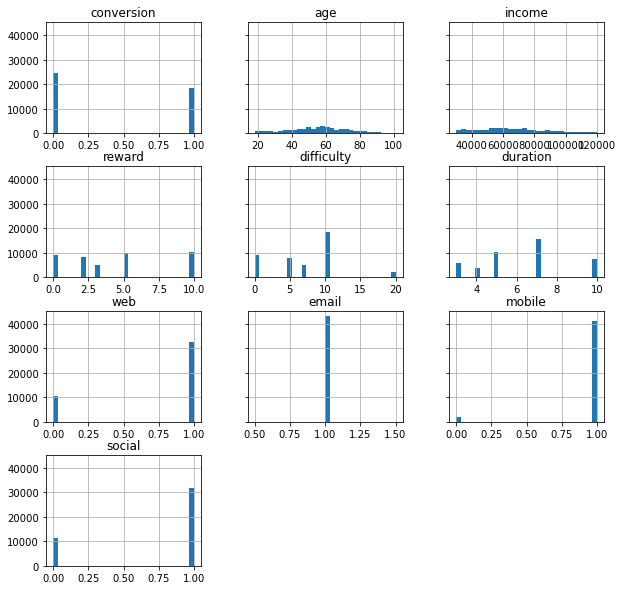

In [35]:
# plot distribution of numeric features
hist = df2.hist(bins=30, sharey=True, figsize=(10,10))

In [36]:
# remove email column as it is all 1's
df2 = df2.drop('email', axis=1)

In [37]:
# distribution of categorical features
print(df2.gender.value_counts())
print(df2.offer_type.value_counts())

M    21266
F    14758
O      557
Name: gender, dtype: int64
bogo             18238
discount         15599
informational     9309
Name: offer_type, dtype: int64


In [38]:
# df2.columns
num_vars = ['age', 'income', 'reward', 'difficulty','duration']
cat_bool_vars = ['gender', 'offer_type', 'web', 'mobile', 'social']

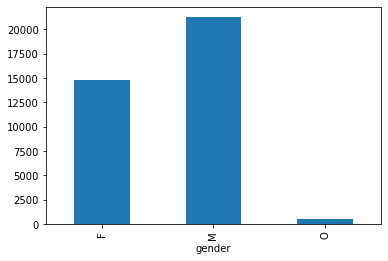

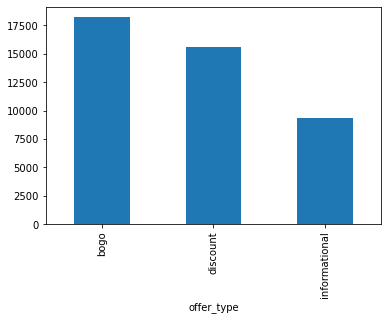

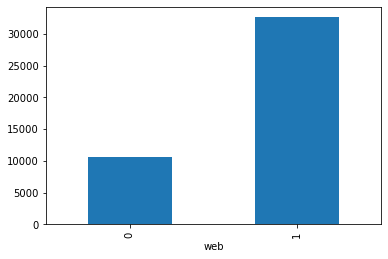

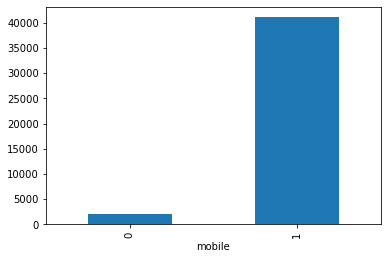

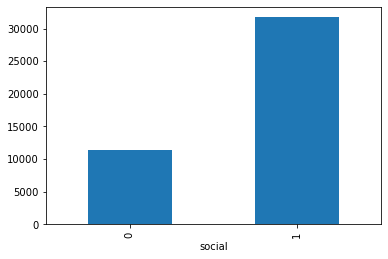

In [39]:
# plot distribution of each categorical and boolean feature
for column in cat_bool_vars:
    valuecounts=df2.groupby(by=column).size()
    valuecounts.plot.bar()
    plt.show()

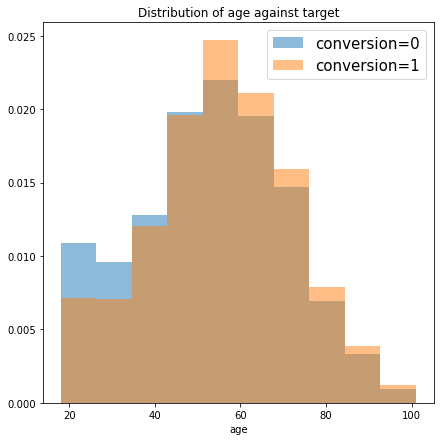

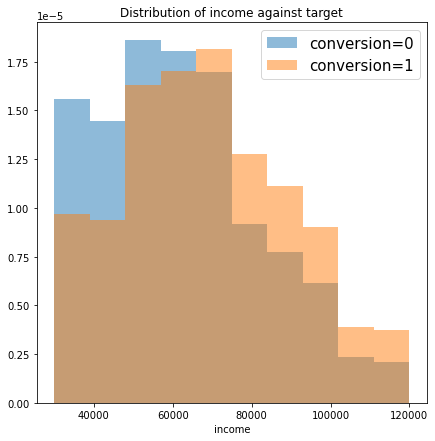

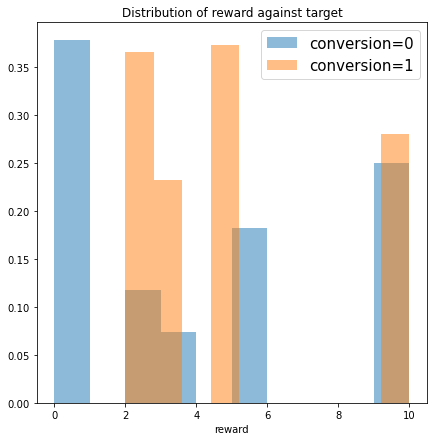

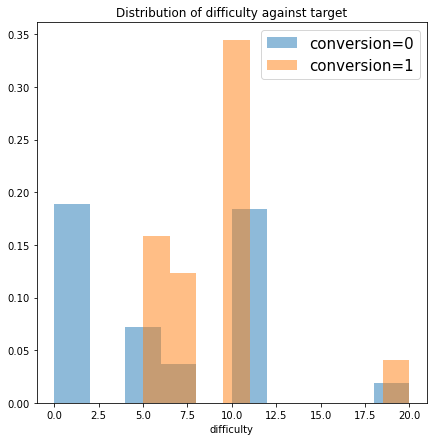

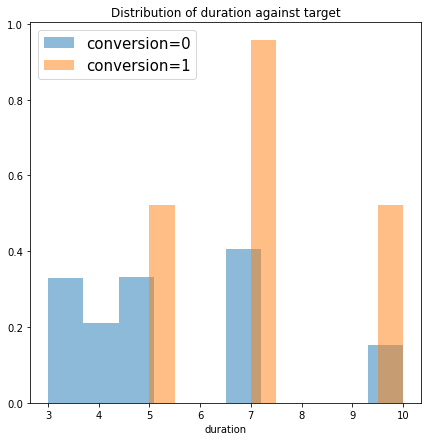

In [40]:
# histograms for each numeric feature against target 
for column in num_vars:
    plt.figure(figsize=(7,7))
    plt.hist(df2[df2.conversion==0][column], density=True, alpha=.5, label='conversion=0');
    plt.hist(df2[df2.conversion==1][column], density=True, alpha=.5, label='conversion=1');
    plt.legend(loc='best', prop={'size': 15});
    plt.xlabel(column);
    plt.title(f'Distribution of {column} against target');
    plt.savefig(f"{column}_num_feat_vs_target.jpg", bbox_inches='tight')

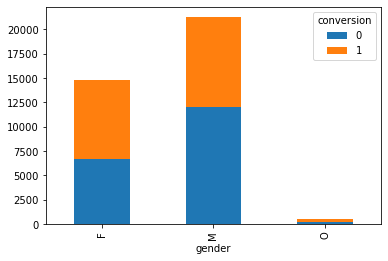

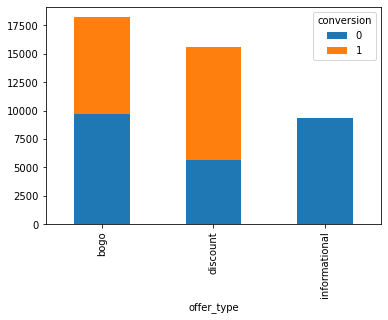

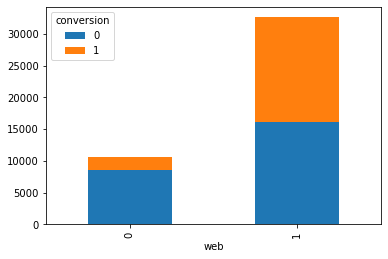

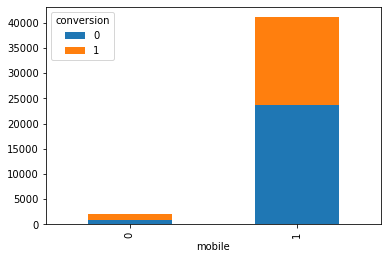

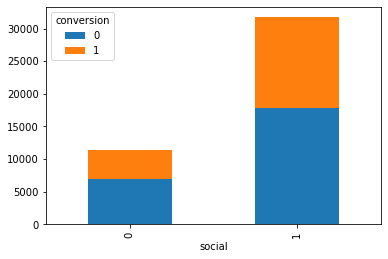

In [41]:
# stacked bar plots for each categorical feature against the target
for column in cat_bool_vars:
    pd.crosstab(df2[column],df2['conversion']).plot(kind="bar",stacked=True)
    plt.savefig(f"{column}_cat_feat_vs_target.jpg", bbox_inches='tight')

### 3.5 Deal with missing values

In [42]:
df2.isnull().sum() / len(df2)

conversion    0.000000
gender        0.152158
age           0.152158
income        0.152158
reward        0.000000
difficulty    0.000000
duration      0.000000
offer_type    0.000000
web           0.000000
mobile        0.000000
social        0.000000
dtype: float64

In [43]:
# create dummy coded columns for categorical variables with additional columns for missing categorical columns
cat_vars = df2.select_dtypes(include='object').columns
df_model = df2.copy()
for col in cat_vars:
    df_model = pd.concat([df_model.drop(col, axis=1), pd.get_dummies(df_model[col], prefix=col, prefix_sep='_', dummy_na = True
                                                               , drop_first=True)], axis=1)

In [44]:
df_model.head()

# the data is ready for modelling

,conversion,age,income,reward,difficulty,duration,web,mobile,social,gender_M,gender_O,gender_nan,offer_type_discount,offer_type_informational,offer_type_nan
0,0,33.0,72000.0,0,0,4,1,1,0,1,0,0,0,1,0
1,0,40.0,57000.0,0,0,4,1,1,0,0,1,0,0,1,0
2,0,26.0,73000.0,0,0,4,1,1,0,0,0,0,0,1,0
3,0,54.0,91000.0,0,0,4,1,1,0,1,0,0,0,1,0
4,0,28.0,68000.0,0,0,4,1,1,0,0,0,0,0,1,0


## 4. Modelling and Evaluation

### 4.1 Build a pipeline to train a Random Forest Classifier

In [45]:
# split data 
X = df_model.drop('conversion', axis=1)
y = df_model['conversion']

# Create training and test sets of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [46]:
# define pipeline to tune preprocessing and modelling step later
pipeline = Pipeline([
        # use simple imputer to impute missing values (for age and income) with mean
        ('imp', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('clf', RandomForestClassifier())
    ])

In [47]:
# fit model to training data
model_rf_1 = pipeline.fit(X_train, y_train)
# predict on test data
y_preds_rf_1 = model_rf_1.predict(X_test)
# evaluate model
print("Results with Random Forest Classifier:")
print(classification_report(y_test, y_preds_rf_1))
# we pay attention to the 2nd row as we want to optimise for the precision, recall and F1 score of predicting conversion
# as well as the 3rd row for accuracy

Results with Random Forest Classifier:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      7478
           1       0.67      0.69      0.68      5466

    accuracy                           0.73     12944
   macro avg       0.72      0.72      0.72     12944
weighted avg       0.73      0.73      0.73     12944



In [48]:
df_results = pd.DataFrame({'Precision': 0.67,
                              'Recall': 0.69,
                             'F1 score': 0.68,
                             'Accuracy': 0.73}, index=['Random Forest'])
df_results

,Precision,Recall,F1 score,Accuracy
Random Forest,0.67,0.69,0.68,0.73


### 4.2 Try LGBM, Catboost and XGBoost algorithms

In [49]:
# define function to try different algorithms and return the test performance scores

def build_model(X_train, y_train, X_test, y_test, algorithm):
    '''Build the pipeline with simple imputer and classifier of choice, train it and 
    return the test performance scores
    
    Args:
        X_train, y_train, X_test, y_test - the dataset split into training and test features and target 
        algorithm - an instance of the algorithm to build the model e.g. RandomForestClassifier()
        
    Returns:
        pipeline - trained pipeline object
        results - report with accuracy, precision, recall and F1 scores on the test data
    '''
    pipeline = Pipeline([
        ('imp', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('clf', algorithm)
    ])
    
    # train pipeline
    model = pipeline.fit(X_train, y_train)
    
    # predict on test data
    y_pred = model.predict(X_test)
    
    # display results
    results = classification_report(y_test, y_pred)
    
    return model, results

In [50]:
model_lgbm_1, results_lgbm_1 = build_model(X_train, y_train, X_test, y_test, LGBMClassifier(n_jobs=-1))
print("Results with LGBM Classifier:")
print(results_lgbm_1)

Results with LGBM Classifier:
              precision    recall  f1-score   support

           0       0.85      0.73      0.79      7478
           1       0.69      0.83      0.75      5466

    accuracy                           0.77     12944
   macro avg       0.77      0.78      0.77     12944
weighted avg       0.78      0.77      0.77     12944



In [51]:
df_results.loc['LGBM'] = [0.69, 0.83, 0.75, 0.77]

In [52]:
model_cb_1, results_cb_1 = build_model(X_train, y_train, X_test, y_test, CatBoostClassifier())
print("Results with CatBoost Classifier:")
print(results_cb_1)

Learning rate set to 0.044148
0:	learn: 0.6537448	total: 67ms	remaining: 1m 6s
1:	learn: 0.6215850	total: 78.5ms	remaining: 39.2s
2:	learn: 0.5932301	total: 86.8ms	remaining: 28.9s
3:	learn: 0.5701020	total: 98.2ms	remaining: 24.4s
4:	learn: 0.5518853	total: 110ms	remaining: 21.8s
5:	learn: 0.5373765	total: 123ms	remaining: 20.4s
6:	learn: 0.5262916	total: 132ms	remaining: 18.7s
7:	learn: 0.5162939	total: 141ms	remaining: 17.5s
8:	learn: 0.5085707	total: 158ms	remaining: 17.4s
9:	learn: 0.5013259	total: 170ms	remaining: 16.9s
10:	learn: 0.4957702	total: 180ms	remaining: 16.2s
11:	learn: 0.4911161	total: 191ms	remaining: 15.7s
12:	learn: 0.4867129	total: 206ms	remaining: 15.6s
13:	learn: 0.4841468	total: 216ms	remaining: 15.2s
14:	learn: 0.4808607	total: 229ms	remaining: 15.1s
15:	learn: 0.4778791	total: 240ms	remaining: 14.8s
16:	learn: 0.4750193	total: 250ms	remaining: 14.4s
17:	learn: 0.4724742	total: 260ms	remaining: 14.2s
18:	learn: 0.4702427	total: 269ms	remaining: 13.9s
19:	learn

182:	learn: 0.4410119	total: 1.9s	remaining: 8.48s
183:	learn: 0.4409763	total: 1.91s	remaining: 8.46s
184:	learn: 0.4409373	total: 1.92s	remaining: 8.45s
185:	learn: 0.4408747	total: 1.93s	remaining: 8.43s
186:	learn: 0.4408385	total: 1.93s	remaining: 8.4s
187:	learn: 0.4407872	total: 1.94s	remaining: 8.4s
188:	learn: 0.4407514	total: 1.95s	remaining: 8.37s
189:	learn: 0.4407232	total: 1.96s	remaining: 8.35s
190:	learn: 0.4406900	total: 1.97s	remaining: 8.32s
191:	learn: 0.4406518	total: 1.97s	remaining: 8.3s
192:	learn: 0.4406013	total: 1.98s	remaining: 8.28s
193:	learn: 0.4405987	total: 1.98s	remaining: 8.24s
194:	learn: 0.4405438	total: 1.99s	remaining: 8.21s
195:	learn: 0.4405338	total: 1.99s	remaining: 8.18s
196:	learn: 0.4404684	total: 2s	remaining: 8.15s
197:	learn: 0.4404148	total: 2.01s	remaining: 8.13s
198:	learn: 0.4403810	total: 2.02s	remaining: 8.14s
199:	learn: 0.4403603	total: 2.03s	remaining: 8.13s
200:	learn: 0.4403133	total: 2.04s	remaining: 8.11s
201:	learn: 0.44027

344:	learn: 0.4335321	total: 3.14s	remaining: 5.97s
345:	learn: 0.4334886	total: 3.15s	remaining: 5.96s
346:	learn: 0.4334367	total: 3.16s	remaining: 5.95s
347:	learn: 0.4334031	total: 3.17s	remaining: 5.94s
348:	learn: 0.4333471	total: 3.18s	remaining: 5.92s
349:	learn: 0.4332873	total: 3.18s	remaining: 5.91s
350:	learn: 0.4332383	total: 3.19s	remaining: 5.9s
351:	learn: 0.4331810	total: 3.2s	remaining: 5.88s
352:	learn: 0.4331511	total: 3.2s	remaining: 5.87s
353:	learn: 0.4331179	total: 3.21s	remaining: 5.86s
354:	learn: 0.4330694	total: 3.21s	remaining: 5.84s
355:	learn: 0.4330305	total: 3.22s	remaining: 5.83s
356:	learn: 0.4329985	total: 3.23s	remaining: 5.81s
357:	learn: 0.4329213	total: 3.23s	remaining: 5.8s
358:	learn: 0.4328677	total: 3.24s	remaining: 5.79s
359:	learn: 0.4328321	total: 3.25s	remaining: 5.77s
360:	learn: 0.4327751	total: 3.25s	remaining: 5.76s
361:	learn: 0.4327369	total: 3.26s	remaining: 5.74s
362:	learn: 0.4326921	total: 3.27s	remaining: 5.73s
363:	learn: 0.43

503:	learn: 0.4269300	total: 4.39s	remaining: 4.32s
504:	learn: 0.4268973	total: 4.4s	remaining: 4.31s
505:	learn: 0.4268641	total: 4.41s	remaining: 4.3s
506:	learn: 0.4268318	total: 4.42s	remaining: 4.3s
507:	learn: 0.4267773	total: 4.43s	remaining: 4.29s
508:	learn: 0.4267349	total: 4.44s	remaining: 4.28s
509:	learn: 0.4267061	total: 4.45s	remaining: 4.27s
510:	learn: 0.4266436	total: 4.46s	remaining: 4.26s
511:	learn: 0.4266127	total: 4.46s	remaining: 4.26s
512:	learn: 0.4265650	total: 4.47s	remaining: 4.25s
513:	learn: 0.4265035	total: 4.48s	remaining: 4.24s
514:	learn: 0.4264620	total: 4.49s	remaining: 4.23s
515:	learn: 0.4264335	total: 4.5s	remaining: 4.22s
516:	learn: 0.4263953	total: 4.51s	remaining: 4.21s
517:	learn: 0.4263488	total: 4.52s	remaining: 4.2s
518:	learn: 0.4263119	total: 4.53s	remaining: 4.19s
519:	learn: 0.4262538	total: 4.54s	remaining: 4.19s
520:	learn: 0.4262192	total: 4.55s	remaining: 4.18s
521:	learn: 0.4261825	total: 4.56s	remaining: 4.17s
522:	learn: 0.426

678:	learn: 0.4204128	total: 5.88s	remaining: 2.78s
679:	learn: 0.4203739	total: 5.89s	remaining: 2.77s
680:	learn: 0.4203577	total: 5.9s	remaining: 2.76s
681:	learn: 0.4203300	total: 5.91s	remaining: 2.76s
682:	learn: 0.4202930	total: 5.92s	remaining: 2.75s
683:	learn: 0.4202661	total: 5.93s	remaining: 2.74s
684:	learn: 0.4202325	total: 5.93s	remaining: 2.73s
685:	learn: 0.4202092	total: 5.94s	remaining: 2.72s
686:	learn: 0.4201891	total: 5.95s	remaining: 2.71s
687:	learn: 0.4201605	total: 5.96s	remaining: 2.7s
688:	learn: 0.4201330	total: 5.96s	remaining: 2.69s
689:	learn: 0.4200930	total: 5.97s	remaining: 2.68s
690:	learn: 0.4200546	total: 5.98s	remaining: 2.67s
691:	learn: 0.4200228	total: 5.99s	remaining: 2.66s
692:	learn: 0.4199891	total: 5.99s	remaining: 2.65s
693:	learn: 0.4199702	total: 6s	remaining: 2.65s
694:	learn: 0.4199511	total: 6.01s	remaining: 2.64s
695:	learn: 0.4199147	total: 6.01s	remaining: 2.63s
696:	learn: 0.4198905	total: 6.02s	remaining: 2.62s
697:	learn: 0.419

843:	learn: 0.4150978	total: 7.42s	remaining: 1.37s
844:	learn: 0.4150553	total: 7.43s	remaining: 1.36s
845:	learn: 0.4150332	total: 7.44s	remaining: 1.35s
846:	learn: 0.4149966	total: 7.45s	remaining: 1.35s
847:	learn: 0.4149699	total: 7.46s	remaining: 1.34s
848:	learn: 0.4149435	total: 7.48s	remaining: 1.33s
849:	learn: 0.4149049	total: 7.49s	remaining: 1.32s
850:	learn: 0.4148587	total: 7.5s	remaining: 1.31s
851:	learn: 0.4148355	total: 7.51s	remaining: 1.3s
852:	learn: 0.4148138	total: 7.52s	remaining: 1.29s
853:	learn: 0.4147820	total: 7.53s	remaining: 1.29s
854:	learn: 0.4147488	total: 7.54s	remaining: 1.28s
855:	learn: 0.4147226	total: 7.55s	remaining: 1.27s
856:	learn: 0.4146908	total: 7.55s	remaining: 1.26s
857:	learn: 0.4146633	total: 7.57s	remaining: 1.25s
858:	learn: 0.4146466	total: 7.57s	remaining: 1.24s
859:	learn: 0.4146132	total: 7.58s	remaining: 1.23s
860:	learn: 0.4145602	total: 7.59s	remaining: 1.23s
861:	learn: 0.4145370	total: 7.6s	remaining: 1.22s
862:	learn: 0.4

In [53]:
df_results.loc['CatBoost'] = [0.69, 0.83, 0.75, 0.77]

In [54]:
model_xgb_1, results_xgb_1 = build_model(X_train, y_train, X_test, y_test, XGBClassifier(n_jobs = -1))
print("Results with XGBoost Classifier:")
print(results_xgb_1)

Results with XGBoost Classifier:
              precision    recall  f1-score   support

           0       0.84      0.74      0.78      7478
           1       0.69      0.81      0.75      5466

    accuracy                           0.77     12944
   macro avg       0.77      0.77      0.77     12944
weighted avg       0.78      0.77      0.77     12944



In [55]:
df_results.loc['XGBoost'] = [0.69, 0.81, 0.75, 0.77]
df_results

,Precision,Recall,F1 score,Accuracy
Random Forest,0.67,0.69,0.68,0.73
LGBM,0.69,0.83,0.75,0.77
CatBoost,0.69,0.83,0.75,0.77
XGBoost,0.69,0.81,0.75,0.77


The 3 models above have similar performance scores. From experience, XGBoost tends to give a better increase in performance from hyperparameter tuning than LGBM and Catboost, hence we proceed with XGBoost.

### 4.3 Tune XGBoost model

In [56]:
model_xgb_1.get_params()

{'memory': None,
 'steps': [('imp', SimpleImputer()),
  ('clf',
   XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                 colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
                 early_stopping_rounds=None, enable_categorical=False,
                 eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
                 importance_type=None, interaction_constraints='',
                 learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
                 max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
                 missing=nan, monotone_constraints='()', n_estimators=100,
                 n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
                 reg_alpha=0, reg_lambda=1, ...))],
 'verbose': False,
 'imp': SimpleImputer(),
 'clf': XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
           

In [53]:
def build_and_tune_model(X_train, y_train, X_test, y_test):
    '''Build the machine learning pipeline in 3 steps:
    Step 1: Structure the pipeline with simple imputer and XGBoost classifier
    Step 2: Specify parameters for grid search
    Step 3: Create grid search
    
    The fit the pipeline on training data, predict on test data and display performance results
    
    Args: 
        X_train, y_train, X_test, y_test - the dataset split into training and test features and target 
        
    Returns:
        model - trained optimal model object 
    '''
    pipeline = Pipeline([
        ('imp', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('clf', XGBClassifier())
    ])
    
    # specify parameters for grid search
    parameters = {
        'clf__max_depth': [3, 6, 10],
        'clf__learning_rate': [0.01, 0.1, 0.2],
        'clf__subsample': [0.3, 0.5, 0.10],     
        'clf__n_estimators': [50, 100, 200],
        'clf__colsample_bytree': [0.5, 0.6, 0.7]
    }
    
    # create grid search object
    model = GridSearchCV(pipeline, param_grid = parameters, scoring='precision', n_jobs=-1, verbose=2)
    
    # fit to training data
    model.fit(X_train, y_train)
    
    # predict on test data
    y_pred = model.predict(X_test)
    
    # display results
    results = classification_report(y_test, y_pred)
    
    return model, results

In [54]:
final_model, final_results = build_and_tune_model(X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


In [106]:
final_model.best_score_

0.7017752108862763

In [55]:
final_model.best_params_

{'clf__colsample_bytree': 0.6,
 'clf__learning_rate': 0.1,
 'clf__max_depth': 3,
 'clf__n_estimators': 50,
 'clf__subsample': 0.1}

## 5. Results

### 5.1 Create baseline to evaluate performance

In [58]:
y_baseline = [1]*len(y_test)

In [59]:
print("Baseline results (predict all 1's):")
print(classification_report(y_test, y_baseline))

Baseline results (predict all 1's):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7478
           1       0.42      1.00      0.59      5466

    accuracy                           0.42     12944
   macro avg       0.21      0.50      0.30     12944
weighted avg       0.18      0.42      0.25     12944



/home/chanzb/miniconda3/envs/jupyterlab/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chanzb/miniconda3/envs/jupyterlab/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chanzb/miniconda3/envs/jupyterlab/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

### 5.2 Compare with final model performance

In [60]:
print("Results with tuned XGBoost Classifier:")
print(final_results)

Results with tuned XGBoost Classifier:
              precision    recall  f1-score   support

           0       0.85      0.73      0.78      7478
           1       0.69      0.83      0.75      5466

    accuracy                           0.77     12944
   macro avg       0.77      0.78      0.77     12944
weighted avg       0.78      0.77      0.77     12944



In [58]:
df_results.loc['Tuned XGBoost (final model)'] = [0.69, 0.83, 0.75, 0.77]
df_results.loc['Baseline'] = [0.42, 1.00, 0.59, 0.42]
df_results

,Precision,Recall,F1 score,Accuracy
Random Forest,0.67,0.69,0.68,0.73
LGBM,0.69,0.83,0.75,0.77
CatBoost,0.69,0.83,0.75,0.77
XGBoost,0.69,0.81,0.75,0.77
Tuned XGBoost (final model),0.69,0.83,0.75,0.77
Baseline,0.42,1.00,0.59,0.42


In [110]:
df_final_results = pd.DataFrame({'Baseline': [0.42, 0.42],
                           'Model': [0.69, 0.77]},
                          index=['Precision', 'Accuracy']).T.reset_index()
df_final_results.rename({'index': 'Type'}, axis=1, inplace=True)
df_final_results = df_final_results.melt(id_vars='Type').rename(columns=str.title)

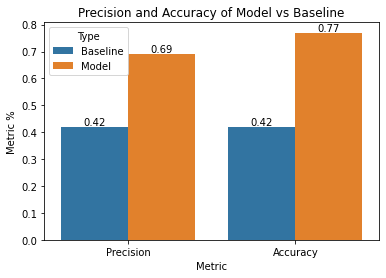

In [111]:
fig, ax = plt.subplots()

sns.barplot(x='Variable', y='Value', hue='Type', data=df_final_results)

plt.title('Precision and Accuracy of Model vs Baseline')
plt.ylabel('Metric %')
plt.xlabel('Metric')

ax.bar_label(ax.containers[-2], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[-1], fmt='%.2f', label_type='edge')
plt.savefig("results.jpg", bbox_inches='tight')

### 5.3 Plot feature importances

<AxesSubplot:>

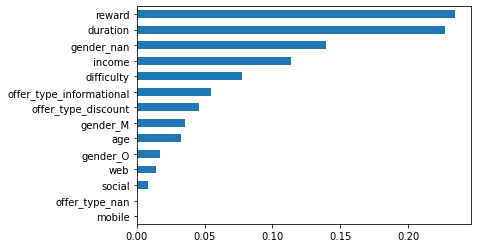

In [79]:
feat_imp = pd.Series(final_model.best_estimator_.named_steps["clf"].feature_importances_, index=X_train.columns)
feat_imp.sort_values().plot(kind='barh')

Unfinished ideas:

This project was completed as part of Udacity’s Data Scientist nanodegree. Given more time, I would have loved to explore the following:
+ Collect more data about each offer such as the day of week and time of day that it was released, and the time that each customer viewed and completed it 
+ Use NLP to analyse how the text used in informational offers is related to its effectiveness
+ Use clustering algorithms like PCA and k-nearest neighbours to segment customers into groups based on behaviour
+ Create a business case for the estimated value of this recommendation system by analysing counterfactuals (customers who complete offers without viewing or receiving them)